<div style="text-align: center;">
    <h1>Classification Problems: Decision Tree</h1>
    <h3>Mohammad Nourbakhsh Marvast</h3>
</div>


In [27]:
import numpy as np;
import matplotlib.pyplot as plt;
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import confusion_matrix

## Decision Tree Class


In [28]:
class TreeNode():
  def __init__(self, uncertainty, num_samples, num_samples_class, class_label):
    self.uncertainty = uncertainty
    self.num_samples = num_samples
    self.num_samples_class = num_samples_class
    self.class_label = class_label
    self.feature_idx = 0
    self.treshold = 0
    self.left = None
    self.right = None


In [29]:
class decision_tree:
  def __init__(self, max_depth= 5, uncertainty_func= lambda prob: -np.sum(prob * np.log2(prob + 1e-16))):
    self.clusters = None
    self.num_samples = None
    self.num_features = None
    self.uncertainty_func = uncertainty_func
    self.max_depth = max_depth
    self.tree = None


  def feature_branch(self, feauture_x, y):

    best_thr = 0
    best_uncertainty = 2
    previous_thr = 0

    feauture_x, y = zip(*sorted(zip(feauture_x, y)))
    feauture_x = np.array(feauture_x)
    y = np.array(y)

    for thr in np.unique(feauture_x):
      y_left = y[feauture_x < thr]
      y_right = y[feauture_x >= thr]

      if len(y_left) == 0 or len(y_right) == 0:
        continue

      prob_l = len(y_left) / len(y)
      prob_r = len(y_right) / len(y)

      prob_left = np.unique(y_left, return_counts=True)[1] / len(y_left)
      prob_right = np.unique(y_right, return_counts=True)[1] / len(y_right)


      uncertainty_left = self.uncertainty_func(prob_left) / self.uncertainty_func(0.5*np.ones(len(prob_left)))
      uncertainty_right = self.uncertainty_func(prob_right) / self.uncertainty_func(0.5*np.ones(len(prob_right)))
      uncertainty_ =  prob_l * uncertainty_left + prob_r * uncertainty_right

      if uncertainty_ < best_uncertainty:
        best_uncertainty = uncertainty_
        best_thr = (previous_thr + thr) / 2

      previous_thr = thr

    return best_thr, best_uncertainty # the branch best threshold

  def best_node(self, X_train, y_train):
    num_features = X_train.shape[1]
    best_feature_idx = 0
    best_feature_thr = 0
    best_feature_uncertainty = 2

    for idx in range(num_features):
      feature_x = X_train[:, idx]
      threshold, uncertainty= self.feature_branch(feature_x, y_train)

      if uncertainty < best_feature_uncertainty:
        best_feature_idx = idx
        best_feature_uncertainty = uncertainty
        best_feature_thr = threshold

    return best_feature_idx, best_feature_thr, best_feature_uncertainty

  def grow_tree(self, X_train, y_train, depth=0):

    num_samples_per_class = np.array([np.sum(y_train == i) for i in self.clusters])
    n = len(num_samples_per_class)
    predicted_class = np.argmax(num_samples_per_class)

    prob =  num_samples_per_class / len(y_train)
    uncertainty = self.uncertainty_func(prob) / self.uncertainty_func(0.5*np.ones(n))


    parent = TreeNode(uncertainty= uncertainty,
                      num_samples= len(y_train),
                      num_samples_class= n,
                      class_label= predicted_class)

    if depth < self.max_depth and uncertainty > 1e-3:
      print(f'depth= {depth}, uncertainty= {uncertainty}')
      feature_idx, feature_thr, feature_uncertainty = self.best_node(X_train, y_train)
      feature = X_train[:, feature_idx]

      left_idx = np.where(feature < feature_thr)[0]
      right_idx = np.where(feature >= feature_thr)[0]

      X_left= X_train[left_idx]
      X_right = X_train[right_idx]
      y_left = y_train[left_idx]
      y_right = y_train[right_idx]

      parent.feature_idx = feature_idx
      parent.treshold = feature_thr

      if len(y_left) > 0:
        parent.left = self.grow_tree(X_left, y_left, depth + 1)
      else:
        parent.left = None

      if len(y_right) > 0:
        parent.right = self.grow_tree(X_right, y_right, depth + 1)
      else:
        parent.right = None

    return parent

  def fit(self, X_train, y_train):
    self.num_samples, self.num_features = X_train.shape
    self.clusters = np.unique(y_train)
    self.tree = self.grow_tree(X_train, y_train)

  def predict(self, X_test):
    y_pred = [self.predict_one(x, self.tree) for x in X_test]
    return np.array(y_pred)

  def predict_one(self, x, tree):
    if tree.left == None and tree.right == None:
      return tree.class_label

    if x[tree.feature_idx] < tree.treshold:
      return self.predict_one(x, tree.left)
    else:
      return self.predict_one(x, tree.right)

## Wine Dataset

In [30]:
from sklearn.datasets import load_wine

In [31]:
# Load dataset
data_frame = load_wine()
data = data_frame.data
target = data_frame.target

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
clf = decision_tree(max_depth= 3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

depth= 0, uncertainty= 1.0459100799621819
depth= 1, uncertainty= 0.9532335731777302
depth= 2, uncertainty= 0.11244062099777999
depth= 2, uncertainty= 0.570229406596666


In [34]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("Decision tree accuracy: ", acc)

Decision tree accuracy:  0.9722222222222222


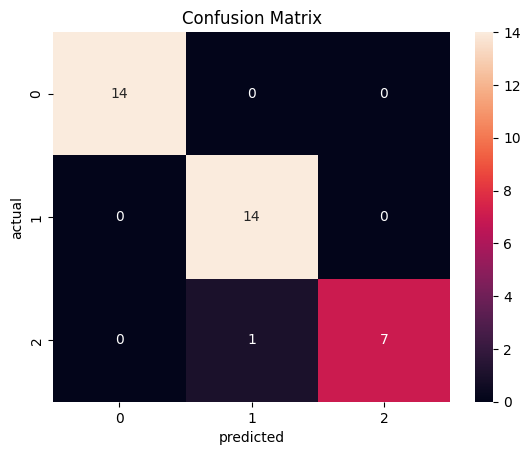

In [35]:
plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()

## Cancer Dataset

In [36]:
from sklearn.datasets import load_breast_cancer

In [37]:
# Load dataset
data_frame = load_breast_cancer()
data = data_frame.data
target = data_frame.target

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
clf = decision_tree (max_depth= 3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

depth= 0, uncertainty= 0.9517626756348311
depth= 1, uncertainty= 0.3143558635927067
depth= 2, uncertainty= 0.13585331486782926
depth= 2, uncertainty= 0.9819407868640976
depth= 1, uncertainty= 0.5165998933608693
depth= 2, uncertainty= 0.9940302114769565


In [40]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("Decision tree accuracy: ", acc)


Decision tree accuracy:  0.956140350877193


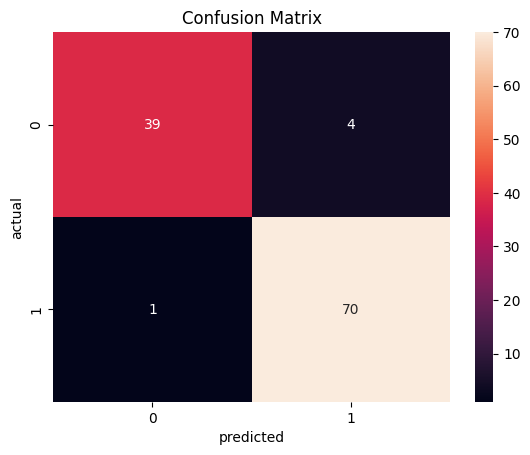

In [41]:
plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()

## Iris Dataset

In [42]:
from sklearn.datasets import load_iris

In [43]:
data_frame = load_iris()
data = data_frame.data
target = data_frame.target

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
clf = decision_tree(max_depth= 3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

depth= 0, uncertainty= 1.056441271958659
depth= 1, uncertainty= 0.7221196008945306
depth= 2, uncertainty= 0.42894327114045333
depth= 2, uncertainty= 0.1247841712488053


Decision tree accuracy:  1.0


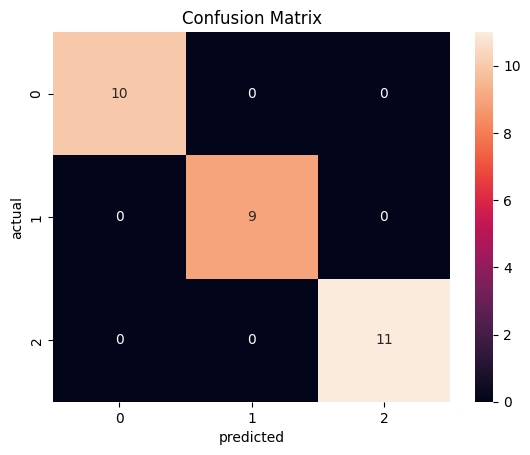

In [46]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("Decision tree accuracy: ", acc)

plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()